In [1]:
import os
from urllib import request
import requests
import gzip
import shutil
from typing import Optional, Union, Tuple, List
from dataclasses import dataclass, field

import causallift
from causallift import CausalLift

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

causallift.__version__
pd.options.display.max_rows = 8
seed = 42

In [2]:
def prepare_data(data: str, **kwargs):

    if data == 'simulated_observational_data':
        """
        # Generate simulated data
        # "Sleeping dogs" (a.k.a. "do-not-disturb"; people who will "buy" if not 
        treated but will not "buy" if treated) can be simulated by negative values 
        in tau parameter.
        # Observational data which includes confounding can be simulated by 
        non-zero values in propensity_coef parameter.  
        # A/B Test (RCT) with a 50:50 split can be simulated by all-zeros values 
        in propensity_coef parameter (default).
        # The first element in each list parameter specifies the intercept.
        """
        from causallift import generate_data

        df = generate_data(
            N=1000, 
            n_features=3, 
            beta=[0,-2,3,-5], # Effect of [intercept and features] on outcome 
            error_std=0.1, 
            tau=[1,-5,-5,10], # Effect of [intercept and features] on treated outcome
            tau_std=0.1, 
            discrete_outcome=True, 
            seed=seed, 
            feature_effect=0, # Effect of beta on treated outxome
            propensity_coef=[0,-1,1,-1], # Effect of [intercept and features] on propensity log-odds for treatment
            index_name='index',
        )
        
    elif data == 'lalonde':
        r""" 
            Lalonde dataset was used to evaluate propensity score in the paper:
            Dehejia, R., & Wahba, S. (1999). Causal Effects in Nonexperimental 
            Studies: Reevaluating the Evaluation of Training Programs. Journal of 
            the American Statistical Association, 94(448), 1053-1062. 
            doi:10.2307/2669919

            Lalonde dataset is now included in R package named "Matching."
            http://sekhon.berkeley.edu/matching/lalonde.html
        """
        import numpy as np
        
        def get_lalonde():
            r""" Load datasets, concatenate, and create features to get data frame 
            similar to 'lalonde' that comes with "Matching.")
            """
            cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
            control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep=r'\s+', header = None, names = cols)
            treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep=r'\s+', header = None, names = cols)
            lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
            lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
            lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
            return lalonde_df
        lalonde_df = get_lalonde()
        
        """ Prepare the input Data Frame. """
        df = lalonde_df.copy()
        df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)
        df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)
        
        # categorize age to 20s, 30s, 40s, and 50s and then one-hot encode age
        df.loc[:,'age'] = df['age'].apply(lambda x:'{:.0f}'.format(x)[:-1]+'0s') 
        df = pd.get_dummies(df, columns=['age'], drop_first=True) 
        
        cols = ['nodegr', 'black', 'hisp', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 
                'educ', 'married', 'u74', 'u75', 'Treatment', 'Outcome']
        df = df[cols]

    elif data == 'criteo':
        save_dir = "./raw_data"
        os.makedirs(save_dir, exist_ok=True)

        criteo_url = "http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz"
        zip_file_name = "raw_data/criteo-research-uplift-v2.1.csv.gz"
        unzip_file_name = "raw_data/criteo-research-uplift-v2.1.csv"
        
        if os.path.isfile(unzip_file_name):
            print("The downloaded file already exists!")
        
        else:
            print("Try to download the raw data from the server...")
            response = requests.get(criteo_url, stream=True)
            total_size_in_bytes = int(response.headers.get("content-length", 0))
            block_size = 1024
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(zip_file_name, "wb") as f:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    f.write(data)
            progress_bar.close()
            print("Finished downloading!!!")
            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("Error, something went wrong!")
                return

            print("Try to unzip the downloaded file")
            with gzip.open(zip_file_name, "rb") as f_in:
                with open (unzip_file_name, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

            os.remove(zip_file_name)
            print("Zip file removed from disk")

        print("Import the csv file into pd.DataFrame")
        df = pd.read_csv(unzip_file_name)
    
    else:
        raise ValueError("No corresponding data found")

    return df

In [42]:
df = prepare_data("criteo")

The downloaded file already exists!
Import the csv file into pd.DataFrame


In [49]:
np.sum(df.treatment == 0)/len(df)
# 15% is treated

0.1499998712408774

In [56]:
subset = pd.concat([df[df["treatment"] == 0].iloc[0:10000], df[df["treatment"] == 1].iloc[0:10000]]).reset_index(drop=True)
# subsetting

In [60]:
subset.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.974809,10.059654,8.761255,2.293959,10.280525,4.115453,-5.116672,4.833815,3.955396,13.190056,5.300375,-0.168679,0,0,0,0
1,16.177822,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
2,12.616365,10.059654,8.497501,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,16.226044,5.300375,-0.168679,0,0,0,0
3,26.683908,10.059654,8.214383,4.679882,10.280525,4.115453,-11.681070,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
4,24.359765,10.059654,8.214383,4.679882,10.280525,4.115453,-11.944313,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0


In [59]:
train_df, eval_df = train_test_split(subset, test_size=0.2, random_state=42, stratify=subset.iloc[:, 12:14])
print(len(train_df), len(eval_df))

16000 4000


In [61]:
train_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
14973,24.678087,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3788,21.871863,10.059654,8.214383,4.679882,10.280525,4.115453,-5.987667,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
1037,26.204993,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
17256,24.097903,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
16862,18.083924,10.059654,8.214383,2.934780,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [62]:
corr = train_df.corr()
corr

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
f0,1.000000,-0.107728,-0.564694,0.367555,-0.167255,0.086392,-0.219291,-0.015057,0.412316,-0.306103,-0.138490,0.140965,-0.044103,-0.092089,-0.175249,-0.140897
f1,-0.107728,1.000000,-0.000115,-0.337571,0.291052,-0.552622,-0.159504,0.128333,-0.235704,0.331741,0.091026,-0.285698,-0.006820,0.159227,0.170176,0.137116
f2,-0.564694,-0.000115,1.000000,-0.024991,0.080392,-0.049219,0.143323,0.056678,-0.489130,0.042031,0.190649,0.007319,0.058116,-0.010813,0.031726,0.035266
f3,0.367555,-0.337571,-0.024991,1.000000,-0.346355,0.331366,0.409152,-0.161732,0.345029,-0.427344,-0.209521,0.287710,0.007095,-0.177168,-0.227919,-0.298691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
treatment,-0.044103,-0.006820,0.058116,0.007095,-0.010578,0.003907,0.030602,-0.000442,0.015896,-0.019407,-0.012919,0.010770,1.000000,0.012974,-0.010783,0.108156
conversion,-0.092089,0.159227,-0.010813,-0.177168,0.408461,-0.147545,-0.088738,0.052109,-0.256503,0.339932,0.128135,-0.455336,0.012974,1.000000,0.407518,0.198575
visit,-0.175249,0.170176,0.031726,-0.227919,0.468861,-0.182292,-0.116342,0.101808,-0.477975,0.551725,0.264629,-0.391389,-0.010783,0.407518,1.000000,0.254879
exposure,-0.140897,0.137116,0.035266,-0.298691,0.181124,-0.187026,-0.156140,0.097149,-0.192433,0.217912,0.102348,-0.155041,0.108156,0.198575,0.254879,1.000000


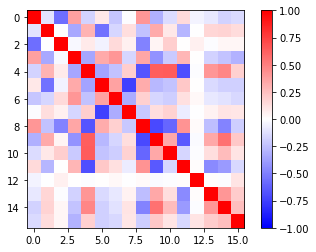

In [63]:
plt.imshow(corr, cmap="bwr")
plt.colorbar()
plt.clim(-1, 1)
plt.show()

In [65]:
pd.crosstab(train_df.treatment, train_df.conversion)/len(train_df)

conversion,0,1
treatment,,
0,0.498437,0.001563
1,0.497625,0.002375


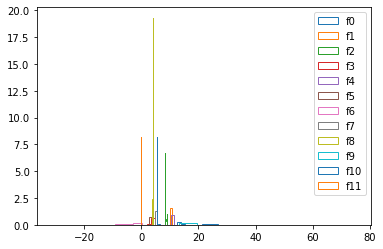

In [68]:
for idx, column in enumerate(df.columns):
    if idx >= len(df.columns) - 4:
        # t and y varaibles
        continue
    plt.hist(df[column], density=True, histtype="step", label=column)
plt.legend()

In [69]:
class UpliftDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        in_features: int,
        t_idx: Optional[int] = None,
        y_idx: Optional[int] = None,
    ):
        t_idx = in_features if t_idx is None else t_idx
        y_idx = in_features + 1 if y_idx is None else y_idx

        self.in_features = in_features
        self.t_idx = t_idx
        self.y_idx = y_idx
        
        self.df = df
        self.X  = self.df.iloc[:, 0:in_features]
        self.t  = self.df.iloc[:, t_idx]
        self.y  = self.df.iloc[:, y_idx]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X.iloc[idx, :].to_numpy(), dtype=torch.float32)
        t = torch.tensor(self.t.iloc[idx], dtype=torch.float32)
        y = torch.tensor(self.y.iloc[idx], dtype=torch.float32)
        return (X, t, y)

In [70]:
train_set = UpliftDataset(train_df, 12)
eval_set  = UpliftDataset(eval_df, 12)

train_dl = DataLoader(train_set, batch_size=128, shuffle=True)
eval_dl  = DataLoader(eval_set, batch_size=128, shuffle=False)

In [71]:
train_set[0]

(tensor([24.6781, 10.0597,  8.2144,  4.6799, 10.2805,  4.1155, -3.2821,  4.8338,
          3.9719, 13.1901,  5.3004, -0.1687]),
 tensor(1.),
 tensor(0.))

In [72]:
class UpliftModel(nn.Module):
    def __init__(
        self,
        in_features: int,
    ):
        super(UpliftModel, self).__init__()
        self.fc = nn.Linear(in_features+1, 1)
        # additional feature for T
    
    def forward(self, x):
        return self.fc(x)

In [73]:
class UpliftWrapper(nn.Module):
    def __init__(
        self,
        in_features: int,
    ):
        super(UpliftWrapper, self).__init__()
        self.in_features = in_features
        self.model = UpliftModel(in_features)
        self.sigmoid = nn.Sigmoid()
        
    def forward(
        self, 
        x: torch.Tensor, 
        t: torch.Tensor,
    ):
        # X shape: (B, N)
        if t.ndim == 2:
            t = t.squeeze()
        B = x.size(0)
        L = x.size(1)
        # print(f"input shape: {x.shape}")

        # first creating the inputs accordingly
        x_0 = torch.cat([x, torch.zeros([B, 1]).to(x.device)], dim=1)
        x_1 = torch.cat([x, torch.ones([B, 1]).to(x.device)], dim=1)
        # print(f"x_0 shape: {x_0.shape}, x_1 shape: {x_1.shape}")

        y_0 = self.sigmoid(self.model(x_0)).squeeze()
        y_1 = self.sigmoid(self.model(x_1)).squeeze()
        # print(f"y_0 shape: {y_0.shape}, y_1 shape: {y_1.shape}")

        pred = torch.where(t == 1, y_1, y_0)

        return {
            "uplift": y_1 - y_0,
            "pred": pred,
        }


In [74]:
class UpliftLoss(nn.Module):
    def __init__(self, 
        propensity_score: float = 0.5, 
        alpha: Optional[float] = None, 
    ):
        super(UpliftLoss, self).__init__()
        
        if alpha > 1 or alpha < 0:
            raise ValueError("alpha must be in [0, 1]")
        self.e_x = propensity_score
        self.alpha = alpha

        self.loss_u = nn.MSELoss()
        self.loss_y = nn.BCEWithLogitsLoss()

    def forward(self, out, t, y):
        z = t * y / self.e_x - (1-t) * y / (1-self.e_x)
        # print(z)
        # variable transformation

        loss_uplift = self.loss_u(z, out["uplift"].squeeze())
        loss_pred   = self.loss_y(y, out["pred"].squeeze())

        loss = (1-self.alpha) * loss_uplift + self.alpha * loss_pred
        return loss

In [75]:
model = UpliftWrapper(12)
criterion = UpliftLoss(propensity_score=0.5, alpha=0.5)

In [76]:
train_set[0][0].unsqueeze(0)

tensor([[24.6781, 10.0597,  8.2144,  4.6799, 10.2805,  4.1155, -3.2821,  4.8338,
          3.9719, 13.1901,  5.3004, -0.1687]])

In [77]:
out = model(train_set[0][0].unsqueeze(0), train_set[0][1])
out

{'uplift': tensor(0.0417, grad_fn=<SubBackward0>),
 'pred': tensor(0.2276, grad_fn=<SWhereBackward>)}

In [78]:
X, t, y = next(iter(train_dl))
out = model(X, t)
# print(out)
# print(out["uplift"].shape, out["pred"].shape)

In [79]:
out["pred"]

tensor([0.9191, 0.9143, 0.9810, 0.2545, 0.2203, 0.0064, 0.7934, 0.0339, 0.4664,
        0.1331, 0.0100, 0.1015, 0.2558, 0.6406, 0.9907, 0.1873, 0.3048, 0.4327,
        0.0715, 0.1978, 0.1694, 0.2492, 0.2934, 0.2751, 0.2985, 0.1150, 0.1635,
        0.0384, 0.3387, 0.6310, 0.3132, 0.0028, 0.6333, 0.1732, 0.0409, 0.2241,
        0.2037, 0.3021, 0.3210, 0.3040, 0.3735, 0.1522, 0.9953, 0.1333, 0.2579,
        0.6311, 0.2903, 0.0089, 0.1163, 0.5155, 0.2423, 0.0247, 0.1151, 0.3508,
        0.2112, 0.3260, 0.1543, 0.0417, 0.3137, 0.6415, 0.2907, 0.6487, 0.0492,
        0.6399, 0.6374, 0.0494, 0.2218, 0.3142, 0.1902, 0.3132, 0.2825, 0.1137,
        0.0797, 0.6337, 0.1073, 0.0812, 0.3128, 0.0590, 0.0412, 0.2153, 0.0790,
        0.0974, 0.2008, 0.2273, 0.0516, 0.2484, 0.8491, 0.2556, 0.5804, 0.1283,
        0.0575, 0.8600, 0.0768, 0.3052, 0.1102, 0.3055, 0.0846, 0.0874, 0.1596,
        0.3218, 0.3067, 0.1989, 0.7021, 0.0196, 0.3674, 0.1013, 0.1235, 0.2505,
        0.3177, 0.0762, 0.2159, 0.2694, 

In [80]:
out["uplift"]

tensor([0.0211, 0.0222, 0.0054, 0.0513, 0.0469, 0.0014, 0.0449, 0.0074, 0.0625,
        0.0267, 0.0029, 0.0257, 0.0454, 0.0563, 0.0021, 0.0419, 0.0512, 0.0633,
        0.0189, 0.0374, 0.0389, 0.0506, 0.0499, 0.0536, 0.0505, 0.0286, 0.0319,
        0.0084, 0.0545, 0.0571, 0.0572, 0.0008, 0.0569, 0.0335, 0.0112, 0.0412,
        0.0382, 0.0509, 0.0528, 0.0511, 0.0575, 0.0359, 0.0010, 0.0268, 0.0457,
        0.0571, 0.0551, 0.0020, 0.0237, 0.0635, 0.0437, 0.0069, 0.0235, 0.0556,
        0.0393, 0.0533, 0.0304, 0.0091, 0.0573, 0.0563, 0.0552, 0.0557, 0.0134,
        0.0564, 0.0566, 0.0134, 0.0471, 0.0522, 0.0424, 0.0521, 0.0544, 0.0233,
        0.0168, 0.0569, 0.0221, 0.0211, 0.0572, 0.0158, 0.0113, 0.0461, 0.0206,
        0.0202, 0.0440, 0.0478, 0.0140, 0.0505, 0.0356, 0.0514, 0.0630, 0.0259,
        0.0124, 0.0280, 0.0201, 0.0565, 0.0276, 0.0566, 0.0178, 0.0226, 0.0313,
        0.0579, 0.0514, 0.0437, 0.0559, 0.0043, 0.0570, 0.0257, 0.0250, 0.0448,
        0.0525, 0.0161, 0.0462, 0.0471, 

In [81]:
loss = criterion(out, t, y)
loss

tensor(0.3474, grad_fn=<AddBackward0>)

In [82]:
model.cuda()

UpliftWrapper(
  (model): UpliftModel(
    (fc): Linear(in_features=13, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [84]:
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

In [ ]:
@dataclass
class UpliftTrainingArguments:
    num_train_epochs: int

    do_train: bool = False
    do_eval: bool  = False
    do_test: bool  = False

    eval_steps: int = field(default=500, )
    logging_steps: int = field(default=500, )
    saving_steps: int = field(default=500, )

class UpliftTrainer:
    def __init__(
        self, 
        args: UpliftTrainingArguments, 
        model: nn.Module,
        train_dataset: Optional[Dataset],
        eval_dataset:  Optional[Dataset],
        test_dataset:  Optional[Dataset],
    ):
        
        self.args  = args
        self.model = model

        self.train_dataset = train_dataset
        self.eval_dataset  = eval_dataset
        self.test_dataset  = test_dataset

    def train(self):
        pass

In [87]:
num_epochs = 10
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch}")

    train_cnt = 0
    train_corrects = 0

    model.train()
    for X, t, y in tqdm(train_dl):
        optimizer.zero_grad()
        train_cnt += X.size(0)

        X = X.cuda()
        t = t.cuda()
        y = y.cuda()

        out = model(X, t)
        loss = criterion(out, t, y)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        pred = np.where(out["pred"].detach().cpu().numpy() > 0.5, 1, 0)
        train_corrects += np.sum(pred == y.cpu().numpy())

    train_accuracies.append(train_corrects/train_cnt)
    print(f"train accuracy: {train_accuracies[-1]}")

    eval_cnt = 0
    eval_corrects = 0

    model.eval()
    with torch.no_grad():
        for X, t, y in tqdm(eval_dl):
            eval_cnt += X.size(0)

            X = X.cuda()
            t = t.cuda()
            y = y.cuda()

            out = model(X, t)
            loss = criterion(out, t, y)
            eval_losses.append(loss.item())

            pred = np.where(out["pred"].detach().cpu().numpy() > 0.5, 1, 0)
            eval_corrects += np.sum(pred == y.cpu().numpy())

    eval_accuracies.append(eval_corrects/eval_cnt)
    print(f"train accuracy: {eval_accuracies[-1]}")

    print()


epoch: 0


100%|██████████| 125/125 [00:02<00:00, 44.02it/s]


train accuracy: 0.8149375


100%|██████████| 32/32 [00:00<00:00, 55.06it/s]


train accuracy: 0.80825

epoch: 1


100%|██████████| 125/125 [00:02<00:00, 46.17it/s]


train accuracy: 0.815875


100%|██████████| 32/32 [00:00<00:00, 48.00it/s]


train accuracy: 0.8085

epoch: 2


100%|██████████| 125/125 [00:02<00:00, 49.02it/s]


train accuracy: 0.8166875


100%|██████████| 32/32 [00:00<00:00, 54.10it/s]


train accuracy: 0.80925

epoch: 3


100%|██████████| 125/125 [00:02<00:00, 47.68it/s]


train accuracy: 0.81725


100%|██████████| 32/32 [00:00<00:00, 54.25it/s]


train accuracy: 0.8095

epoch: 4


100%|██████████| 125/125 [00:02<00:00, 44.84it/s]


train accuracy: 0.817625


100%|██████████| 32/32 [00:00<00:00, 48.19it/s]


train accuracy: 0.80975

epoch: 5


100%|██████████| 125/125 [00:02<00:00, 49.88it/s]


train accuracy: 0.8181875


100%|██████████| 32/32 [00:00<00:00, 53.61it/s]


train accuracy: 0.8105

epoch: 6


 22%|██▏       | 27/125 [00:00<00:01, 49.70it/s]


KeyboardInterrupt: 

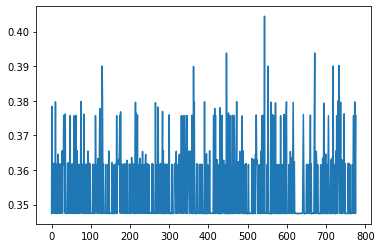

In [89]:
plt.plot(train_losses)